<a href="https://colab.research.google.com/github/mdaugherity/Unfolding/blob/main/GaussExample_min.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

An actual working version of the example code from
https://github.com/hep-lbdl/OmniFold/blob/main/GaussianExample_minimal.ipynb

Their code in github has a bug in plotting the omnifolded results where lw="2" should be lw=2.    

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model

#import omnifold as of
import os
import tensorflow as tf
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split


#OMNIFOLD LIB

In [ ]:
# FROM OMNIFOLD.py
import numpy as np


def reweight(events,model,batch_size=10000):
    f = model.predict(events, batch_size=batch_size)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights))

# Binary crossentropy for classifying two samples with weights
# Weights are "hidden" by zipping in y_true (the labels)

def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))

    return K.mean(t_loss)

def omnifold(theta0,theta_unknown_S,iterations,model,verbose=0):

    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))

    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))

    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels_unknown))

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))

    for i in range(iterations):

        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            pass

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data

        if (verbose>0):
            print("STEP 1\n")
            pass

        weights_1 = np.concatenate((weights_push, np.ones(len(theta_unknown_S))))

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(xvals_1, yvals_1, weights_1)

        # zip ("hide") the weights with the labels
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])

        model.fit(X_train_1,
                  Y_train_1,
                  epochs=20,
                  batch_size=10000,
                  validation_data=(X_test_1, Y_test_1),
                  verbose=verbose)

        weights_pull = weights_push * reweight(theta0_S,model)
        weights[i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.

        if (verbose>0):
            print("\nSTEP 2\n")
            pass

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(xvals_2, yvals_2, weights_2)

        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)

        model.compile(loss=weighted_binary_crossentropy,
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  epochs=20,
                  batch_size=2000,
                  validation_data=(X_test_2, Y_test_2),
                  verbose=verbose)

        weights_push = reweight(theta0_G,model)
        weights[i, 1:2, :] = weights_push
        pass

    return weights

# GAUSS MIN

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
#tf.config.experimental.set_virtual_device_configuration(
#    gpus[1],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
N = 10**5

#Synthetic
theta0_G = np.random.normal(0.2,0.8,N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta0_G])  # Detector smearing for synthetic sample

theta0 = np.stack([theta0_G, theta0_S], axis=1)

#Natural
theta_unknown_G = np.random.normal(0,1, N)
theta_unknown_S = np.array([(x + np.random.normal(0, 0.5)) for x in theta_unknown_G])

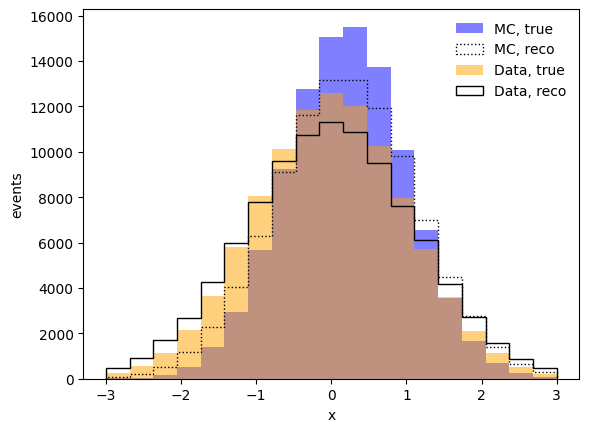

In [ ]:
_,_,_=plt.hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S,bins=np.linspace(-3,3,20),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S,bins=np.linspace(-3,3,20),histtype="step",color='black',label="Data, reco")
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

In [ ]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
myweights = omnifold(theta0,theta_unknown_S,8,model,1)  #omnifold(theta0,theta_unknown_S,iterations,model,verbose=0):


ITERATION: 1

STEP 1

Epoch 1/20
15/15 [==============================] - 2s 17ms/step - loss: 0.6823 - accuracy: 0.4278 - val_loss: 0.6818 - val_accuracy: 0.4079
Epoch 2/20
15/15 [==============================] - 0s 6ms/step - loss: 0.6813 - accuracy: 0.4196 - val_loss: 0.6814 - val_accuracy: 0.4373
Epoch 3/20
15/15 [==============================] - 0s 6ms/step - loss: 0.6812 - accuracy: 0.4409 - val_loss: 0.6813 - val_accuracy: 0.4392
Epoch 4/20
15/15 [==============================] - 0s 6ms/step - loss: 0.6811 - accuracy: 0.4332 - val_loss: 0.6813 - val_accuracy: 0.4322
Epoch 5/20
15/15 [==============================] - 0s 6ms/step - loss: 0.6811 - accuracy: 0.4349 - val_loss: 0.6813 - val_accuracy: 0.4394
Epoch 6/20
15/15 [==============================] - 0s 8ms/step - loss: 0.6811 - accuracy: 0.4352 - val_loss: 0.6813 - val_accuracy: 0.4354
Epoch 7/20
15/15 [==============================] - 0s 6ms/step - loss: 0.6811 - accuracy: 0.4367 - val_loss: 0.6813 - val_accuracy: 0.4

In [ ]:
myweights.shape

(8, 2, 100000)

In [ ]:
print(myweights.min())
print(myweights.max())

0.7156718969345093
86.65205383300781


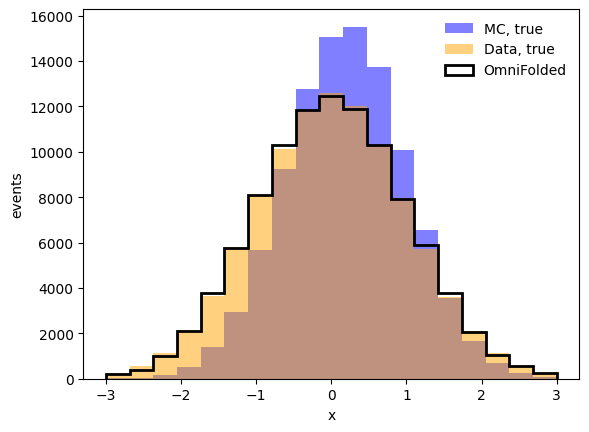

In [ ]:
_,_,_=plt.hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta0_G,weights=myweights[-1, 0, :], bins=np.linspace(-3,3,20),color='black',histtype="step",label="OmniFolded",lw=2) # BUG: remove quote from lw

plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

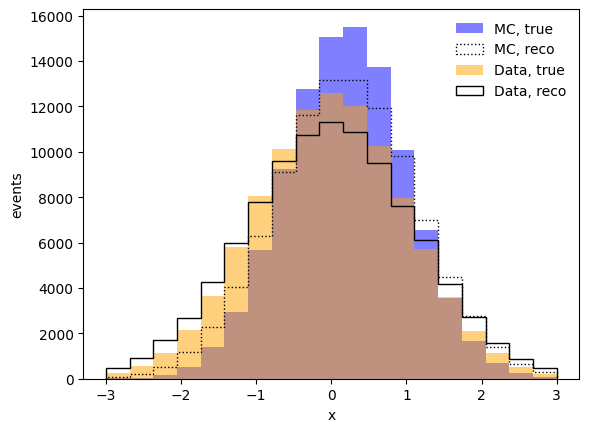

In [ ]:
#OLD PLOT
_,_,_=plt.hist(theta0_G,bins=np.linspace(-3,3,20),color='blue',alpha=0.5,label="MC, true")
_,_,_=plt.hist(theta0_S,bins=np.linspace(-3,3,20),histtype="step",color='black',ls=':',label="MC, reco")
_,_,_=plt.hist(theta_unknown_G,bins=np.linspace(-3,3,20),color='orange',alpha=0.5,label="Data, true")
_,_,_=plt.hist(theta_unknown_S,bins=np.linspace(-3,3,20),histtype="step",color='black',label="Data, reco")
#_,_,_=plt.hist(theta0_G,weights=myweights[-1, 0, :], bins=np.linspace(-3,3,20),color='black',histtype="step",label="OmniFolded",lw=2) # BUG: remove quote from lw
plt.xlabel("x")
plt.ylabel("events")
plt.legend(frameon=False)

In [ ]:
theta_unknown_S.shape

(100000,)

In [ ]:
myweights[-1, 0, :].shape

(100000,)

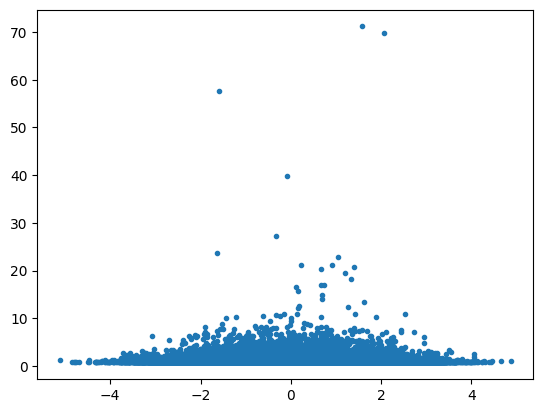

In [ ]:
plt.plot(theta_unknown_S, myweights[-1, 0, :],'.')